In [2]:
import os
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
from utils.exp_utils import list_concept_names, list_exp_names

In [3]:
class ExpScoreKeeper:
    def __init__(self, base_path, dataset_name, exp_name, model_name):
        self.base_path = base_path
        self.dataset_name = dataset_name
        self.exp_name = exp_name
        self.model_name = model_name
        with open(f"{base_path}/{dataset_name}/{exp_name}_{model_name}.pkl", "rb") as f:
            self.data = pk.load(f)
        self.concept = list(self.data.keys())

        self.consistency = np.mean([self.data[concept]["consistency_score"] for concept in self.concept])
        self.distinction = np.mean([self.data[concept]["distinction_score"] for concept in self.concept])
        self.relevance = np.mean([self.data[concept]["relevance_score"] for concept in self.concept])

        self.consistency_std = np.std([self.data[concept]["consistency_score"] for concept in self.concept])
        self.distinction_std = np.std([self.data[concept]["distinction_score"] for concept in self.concept])
        self.relevance_std = np.std([self.data[concept]["relevance_score"] for concept in self.concept])

    def __str__(self):
        return f"""
Concept: {self.concept}
Concept Length: {len(self.concept)}
Base Path: {self.base_path}
Dataset Name: {self.dataset_name}
Experiment Name: {self.exp_name}
Model Name: {self.model_name}

Consistency: {self.consistency}
Distinction: {self.distinction}
relevance: {self.relevance}

Consistency Std: {self.consistency_std}
Distinction Std: {self.distinction_std}
relevance Std: {self.relevance_std}
"""


In [4]:
base_path = "/home/jack/Code/Research/instree_analysis/experiment_image/scores"
dataset_name = "v2_sub_clip"

exp_names = list_exp_names(dataset_name)
cpt_names = list_concept_names(dataset_name)

===== Experiment names for v2_sub_clip: =====
20250425_instree_fixed
20250426_0410
20250427_0426_0.95
===== Total experiments: 3 =====
===== Concept names for v2_sub_clip: =====
buddha
canada_bear
cat_statue
colorful_teapot
decoritems_woodenpot
elephant
green_dall
mug_buildings
mug_skulls
physics_mug
plushie_tortoise
red_teapot
round_bird
===== Total concepts: 13 =====


In [5]:
analysis_name = exp_names
sk_clip = []
sk_dino = []
for model_name in ["clip", "dino"]:
    for exp_name in exp_names:
        sk = ExpScoreKeeper(base_path, dataset_name, exp_name, model_name)
        if model_name == "clip":
            sk_clip.append(sk)
        else:
            sk_dino.append(sk)

In [6]:
for sk in sk_clip:
    print(sk)

print("========================================")

for sk in sk_dino:
    print(sk)


Concept: ['green_dall', 'mug_buildings', 'buddha', 'canada_bear', 'decoritems_woodenpot', 'mug_skulls', 'plushie_tortoise', 'cat_statue', 'red_teapot', 'round_bird', 'colorful_teapot', 'elephant', 'physics_mug']
Concept Length: 13
Base Path: /home/jack/Code/Research/instree_analysis/experiment_image/scores
Dataset Name: v2_sub_clip
Experiment Name: 20250425_instree_fixed
Model Name: clip

Consistency: 1.4045417308807373
Distinction: -0.5223029851913452
relevance: 1.2373608350753784

Consistency Std: 0.11391079425811768
Distinction Std: 0.04860550910234451
relevance Std: 0.11221794784069061


Concept: ['green_dall', 'mug_buildings', 'buddha', 'canada_bear', 'decoritems_woodenpot', 'mug_skulls', 'plushie_tortoise', 'cat_statue', 'red_teapot', 'round_bird', 'colorful_teapot', 'elephant', 'physics_mug']
Concept Length: 13
Base Path: /home/jack/Code/Research/instree_analysis/experiment_image/scores
Dataset Name: v2_sub_clip
Experiment Name: 20250426_0410
Model Name: clip

Consistency: 1.45

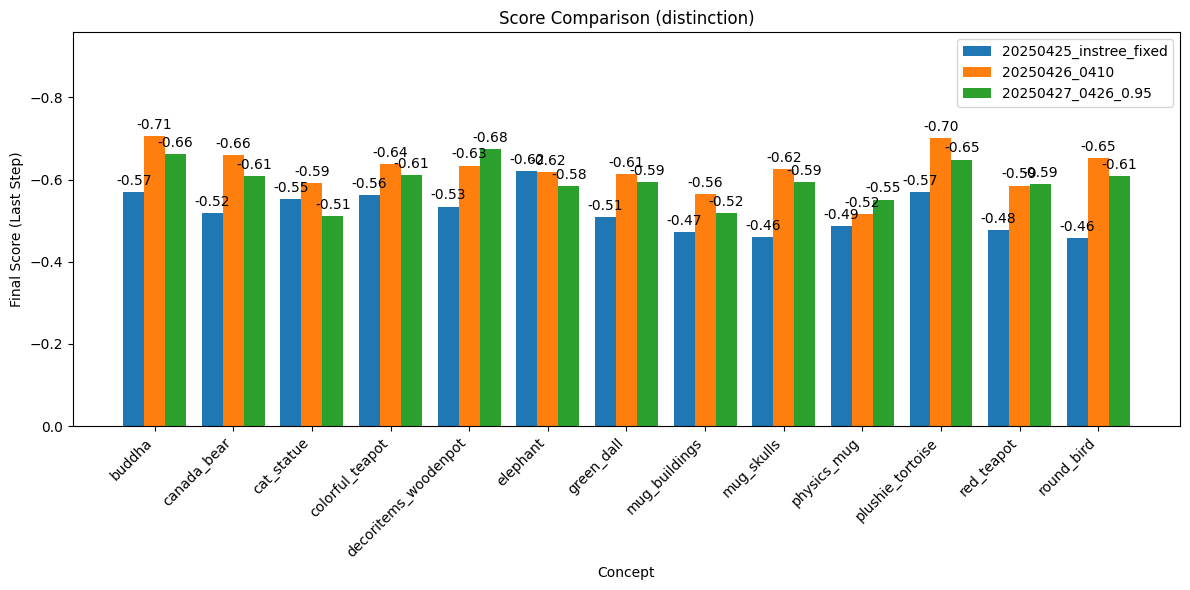

In [9]:
def plot_concept_comparison(dict_list, field='consistency', title='Score Comparison'):
    title += " ({})".format(field)
    label_list = [dict.exp_name for dict in dict_list]
    
    # Get common concepts across all dictionaries
    concept_sets = [set(d.concept) for d in dict_list]
    common_concepts = sorted(set.intersection(*concept_sets))
    
    if not common_concepts:
        print("No common concepts to compare.")
        return

    n_dicts = len(dict_list)
    x = np.arange(len(common_concepts))
    width = 0.8 / n_dicts  # Adjust total bar width

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (d, label) in enumerate(zip(dict_list, label_list)):
        scores = [d.data[c][field+"_score"] for c in common_concepts]
        bars = ax.bar(x + i * width - (n_dicts - 1) * width / 2, scores, width, label=label)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_xlabel('Concept')
    ax.set_ylabel('Final Score (Last Step)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(common_concepts, rotation=45, ha='right')
    ylim = max(max([d.data[c][field+"_score"] for c in common_concepts]) for d in dict_list) 
    ylim += np.sign(ylim) * 0.5
    ax.set_ylim(0, ylim)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_concept_comparison(sk_clip, field='distinction')


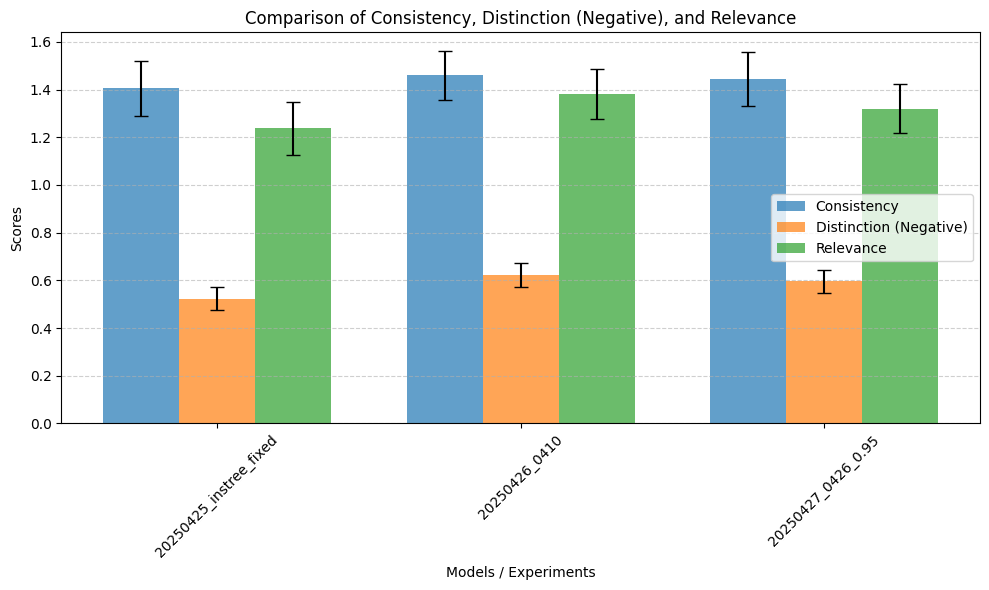

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_scores_one_plot(score_keepers):
    # Extracting model names and experiment names
    model_names = [sk.model_name for sk in score_keepers]
    exp_names = [sk.exp_name for sk in score_keepers]

    # Metrics data
    metrics = ["consistency", "distinction", "relevance"]
    means = {
        "consistency": [sk.consistency for sk in score_keepers],
        "distinction": [-sk.distinction for sk in score_keepers],  # Negating distinction
        "relevance": [sk.relevance for sk in score_keepers]
    }
    stds = {
        "consistency": [sk.consistency_std for sk in score_keepers],
        "distinction": [sk.distinction_std for sk in score_keepers],
        "relevance": [sk.relevance_std for sk in score_keepers]
    }

    x = np.arange(len(score_keepers))  # x locations for the bars
    width = 0.25  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plots for each metric
    ax.bar(x - width, means["consistency"], width, yerr=stds["consistency"], capsize=5, label='Consistency', alpha=0.7)
    ax.bar(x, means["distinction"], width, yerr=stds["distinction"], capsize=5, label='Distinction (Negative)', alpha=0.7)
    ax.bar(x + width, means["relevance"], width, yerr=stds["relevance"], capsize=5, label='Relevance', alpha=0.7)

    # Labels and Titles
    ax.set_xlabel('Models / Experiments')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Consistency, Distinction (Negative), and Relevance')
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names, rotation=45)
    ax.legend()

    # Grid and Layout
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()
plot_all_scores_one_plot(sk_clip)